In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [125]:
df = pd.read_csv('model_data')
df

,Senior Citizen,Partner,Dependents,Tenure Months,Online Backup,Device Protection,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,...,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,0,0,2,2,0,0,0,1,53.85,...,True,False,False,True,False,False,False,False,False,True
1,0,0,1,2,0,0,0,0,1,70.70,...,True,False,False,True,False,False,False,False,True,False
2,0,0,1,8,0,2,2,2,1,99.65,...,True,False,False,True,False,False,False,False,True,False
3,0,1,1,28,0,2,2,2,1,104.80,...,False,False,True,True,False,False,False,False,True,False
4,0,0,1,49,2,2,2,2,1,103.70,...,True,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,72,1,1,1,1,1,21.15,...,False,True,False,False,False,True,True,False,False,False
7039,0,1,1,24,0,2,2,2,1,84.80,...,False,False,True,False,True,False,False,False,False,True
7040,0,1,1,72,2,2,2,2,1,103.20,...,True,False,False,False,True,False,False,True,False,False
7041,0,1,1,11,0,0,0,0,1,29.60,...,True,False,False,True,False,False,False,False,True,False


In [126]:
df.groupby('Churn Label')['Churn Label'].count()

Churn Label
0    5174
1    1869
Name: Churn Label, dtype: int64

Unbalanced data is not good for binary classification because it can lead to biased model performance and inaccurate predictions. If the data is unbalanced, a classifier that always predicts the majority class can achieve a high accuracy rate, but such a model may not be useful in practice. To address this issue, various techniques can be used to balance the data, such as undersampling the majority class or oversampling the minority class. These techniques can help to ensure that the classifier is trained on a more balanced set of data and is therefore better equipped to make accurate predictions on new, unseen data.

We will use the Synthetic Minority Oversampling technique in order to balance our classes

The Synthetic Minority Oversampling Technique (SMOTE) is a algorithmic technique for oversampling the minority class in an imbalanced dataset for binary classification. SMOTE works by creating synthetic samples of the minority class. It does this by selecting a minority class sample and finding its k-nearest neighbors in the feature space. It then creates new synthetic samples by interpolating between the selected sample and its k-nearest neighbors. Specifically, SMOTE generates new samples by randomly selecting one of the k-nearest neighbors and then computing the difference between that neighbor and the original sample. It then multiplies this difference by a random number between 0 and 1 and adds the result to the original sample to create the synthetic sample.

In [127]:
smote = SMOTE(sampling_strategy=1)

In [128]:
X = df.drop(columns=['Churn Label'])  # Features
y = df['Churn Label']  # Target
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [129]:
#Identify continuous features for scaling
continuous_columns = ['Tenure Months', 'Monthly Charges']  

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# transform training set
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns].copy())
# Transform the test set
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns].copy())

In [130]:
def model(method, X_train, y_train, X_test, y_test):
    # Train the model
    method.fit(X_train, y_train)
    probs = method.predict_proba(X_test)[:, 1]  # Get probabilities
    
    # Make predictions on test data and calculate confusion matrix
    predictions = method.predict(X_test)
    c_matrix = confusion_matrix(y_test, predictions)
    
    # Calculate label percentages and create label strings with counts and percentages
    row_sums = np.sum(c_matrix, axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    percentages = (c_matrix / row_sums * 100).round(2)
    labels = [[f"{c_matrix[i, j]} ({percentages[i, j]:.2f}%)" for j in range(c_matrix.shape[1])] for i in range(c_matrix.shape[0])]
    
    sns.heatmap(c_matrix, annot=np.asarray(labels), fmt='', cmap='coolwarm')
    
    # Evaluate model performance and print results
    print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(y_test, predictions)))
    print("Model accuracy: ", '{:.2%}'.format(accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions))

I did a  randomized CV search to get the best parameters for the model

ROC AUC:  86.34%
Model accuracy:  86.33%
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1049
           1       0.85      0.87      0.86      1021

    accuracy                           0.86      2070
   macro avg       0.86      0.86      0.86      2070
weighted avg       0.86      0.86      0.86      2070



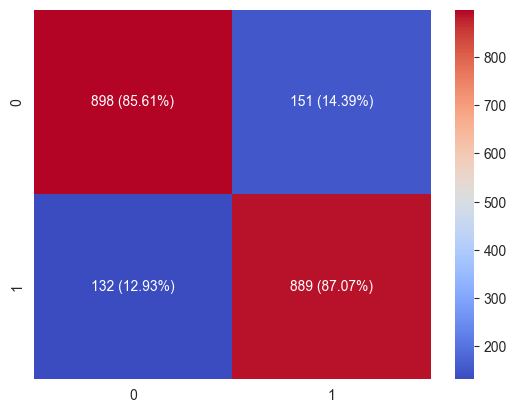

In [131]:
xgb = XGBClassifier(learning_rate= 0.01,max_depth = 4,n_estimators = 3000)
model(xgb,X_train,y_train,X_test,y_test)

In general, for churn prediction, minimizing false negatives (i.e., correctly identifying all customers who are likely to churn) may be more important than minimizing false positives (i.e., incorrectly identifying customers as likely to churn when they are not). So we for business could be more useful to look at F1 score than accuracy, for example. An F1 score of 86% is generally considered to be a good score for a binary classification model. But not perfect and there are a lot of ways to improve it, especially with real customer data.

Thank you for reading my notebook! I'm glad if it was helpful <3

### Word Cloud
For more exploration lets create a word cloud of the churned reason so we can help this business in active next steps

In [133]:
import re
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [149]:
data = pd.read_csv('Telco_customer_churn.csv')
data = data[['Churn Reason']].dropna()
data

,Churn Reason
0,Competitor made better offer
1,Moved
2,Moved
3,Moved
4,Competitor had better devices
...,...
1864,Competitor offered higher download speeds
1865,Competitor offered higher download speeds
1866,Competitor offered higher download speeds
1867,Competitor offered more data


In [150]:
def remove_special_characters(text):
    return re.sub(r"[^a-zA-Z\s]", " ", text)
data['Churn Reason_cleaned'] = data['Churn Reason'].apply(remove_special_characters)
data

,Churn Reason,Churn Reason_cleaned
0,Competitor made better offer,Competitor made better offer
1,Moved,Moved
2,Moved,Moved
3,Moved,Moved
4,Competitor had better devices,Competitor had better devices
...,...,...
1864,Competitor offered higher download speeds,Competitor offered higher download speeds
1865,Competitor offered higher download speeds,Competitor offered higher download speeds
1866,Competitor offered higher download speeds,Competitor offered higher download speeds
1867,Competitor offered more data,Competitor offered more data


In [151]:
data['Churn Reason_cleaned'] = data['Churn Reason_cleaned'].apply(lambda x : x.lower())

Tokenisation - breaks downs sentences into words

In [162]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fibia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fibia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [163]:
data['tokenized_note'] = data['Churn Reason_cleaned'].apply(word_tokenize)

lemmatization - reducing words to its root form

In [165]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fibia\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fibia\AppData\Roaming\nltk_data...


True

In [166]:
lemmatizer = WordNetLemmatizer()
data['lemmatized_text'] = data['tokenized_note'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [169]:
#remove stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fibia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [170]:
stopwords = set(stopwords.words('english'))
data['lemmatized_text'] = data['lemmatized_text'].apply(lambda x: [word for word in x if word not in stopwords])

In [175]:
#join all words
all_words = ' '.join([' '.join(words) for words in data['lemmatized_text']])

'competitor made better offer moved moved moved competitor better device competitor offered higher download speed competitor offered data competitor made better offer competitor better device competitor better device competitor offered higher download speed competitor offered higher download speed competitor offered higher download speed competitor offered data competitor offered data competitor offered data competitor made better offer competitor made better offer price high product dissatisfaction service dissatisfaction lack self service website network reliability limited range service lack affordable download upload speed long distance charge extra data charge price high product dissatisfaction service dissatisfaction lack self service website network reliability know know know poor expertise online support poor expertise phone support price high product dissatisfaction service dissatisfaction lack self service website network reliability limited range service lack affordable down

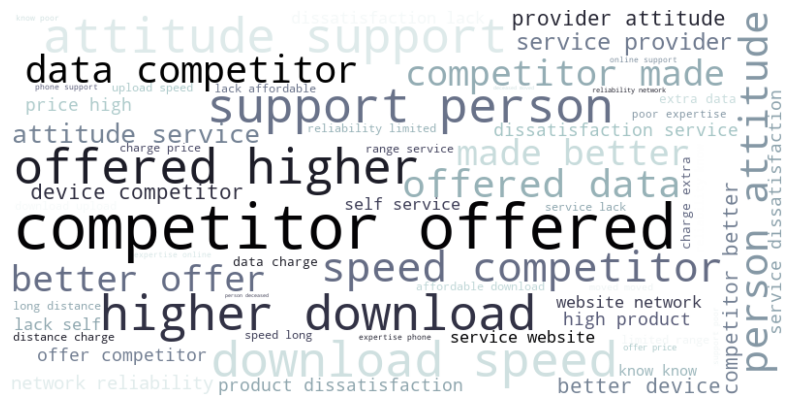

In [181]:
#wordcloud
wordCloud = WordCloud(width=800, height=400, background_color='white', colormap='bone').generate(all_words)

plt.figure(figsize = (10, 10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Let's make it more fun and put our word cloud in a shape

In [178]:
from PIL import image
import numpy as np

ImportError: cannot import name 'image' from 'PIL' (C:\Users\fibia\Documents\busa545\alexanalytystYoutubeProject\.venv\Lib\site-packages\PIL\__init__.py)

...ummmm yeah
         not giving up just time for a new project now.